# ANÁLISIS LTV

In [1]:
#Cargar librerías

import pandas as pd

# Cargar los datos

productos = pd.read_csv('00_Datasets/productos_final.csv', parse_dates = ['Fecha'])

clientes = pd.read_csv('00_Datasets/clientes_final.csv', parse_dates=['Fecha_Nacimiento'])


In [2]:
df_temp = pd.read_csv('00_Datasets/clientes_final.csv')
print(df_temp.columns)

Index(['ID_Cliente', 'Fecha_Nacimiento', 'Genero', 'Codigo_Postal',
       'Nivel_Educativo', 'Ocupacion', 'Tamano_Hogar', 'CAC'],
      dtype='object')


In [3]:
clientes.head(10)

,ID_Cliente,Fecha_Nacimiento,Genero,Codigo_Postal,Nivel_Educativo,Ocupacion,Tamano_Hogar,CAC
0,1,1969-11-23,Hombre,46001,Universitario,Empleado,4-5 personas,184.31
1,2,1973-08-07,Hombre,7003,Sin estudios,Empleado,1 persona,31.60
2,3,1967-06-03,Mujer,11001,Bachillerato,Estudiante,4-5 personas,29.33
3,4,1975-10-22,Hombre,38002,Bachillerato,Empleado,2-3 personas,63.67
4,5,1997-07-12,Mujer,28003,Universitario,Estudiante,2-3 personas,11.13
5,6,1977-11-25,Mujer,3001,Desconocido,Empleado,4-5 personas,41.58
6,7,1961-05-23,Mujer,46002,Máster,Desconocido,2-3 personas,33.84
7,8,1983-02-02,Mujer,12001,Bachillerato,Autónomo,4-5 personas,70.91
8,9,2003-08-21,Mujer,41003,Universitario,Autónomo,2-3 personas,176.26
9,10,1974-02-14,Mujer,29003,Desconocido,Desempleado,4-5 personas,156.31


In [4]:
productos.head(10)

,ID_Cliente,Fecha,ID_Transaccion,Categoria_Producto,Producto,Coste_Unitario,Cantidad,Precio_Unitario,Total_Venta
0,1,2023-01-21,3442,0H2,6OUVC,7.64,4.0,10.50,42.00
1,1,2023-01-21,3442,N8U,CEBU8,4.57,4.0,5.79,23.16
2,2,2023-03-24,14177,TVL,2SLS0,4.60,3.0,7.77,23.31
3,2,2023-06-19,30451,F9B,GZ6VU,9.04,3.0,15.00,45.00
4,3,2023-01-01,90,LPF,Y1M2E,3.37,4.0,4.08,16.32
5,3,2023-01-01,90,TW8,WHV3G,1.15,3.0,1.38,4.14
6,3,2023-01-01,90,TW8,WALAE,0.89,3.0,1.38,4.14
7,4,2023-07-11,34042,69B,APEJQ,3.48,5.0,6.69,33.45
8,4,2023-11-09,54618,YMJ,QR49F,5.31,4.0,7.37,29.48
9,4,2023-11-09,54618,29A,RBNO8,5.67,4.0,8.65,34.60


In [5]:
#crear columna mes transacción

productos['MesTransaccion'] = productos['Fecha'].dt.to_period('M')

# Añadir mes de cohorte
productos['MesCohorte'] = productos.groupby('ID_Cliente')['MesTransaccion'].transform('min')

# eliminar registros de cohortes no completas
resultados = productos[productos['MesCohorte'] <= '2023-07']

# transformamos las variables Mes a date datetime
resultados = resultados.copy()
resultados['MesTransaccion'] = pd.to_datetime(resultados['MesTransaccion'].astype(str), format = '%Y-%m')
resultados['MesCohorte'] = pd.to_datetime(resultados['MesCohorte'].astype(str), format = '%Y-%m')

# Eliminar registros que no entran en el mes de estudio
resultados_filtrados = resultados[resultados['MesTransaccion'] <= resultados['MesCohorte'] + pd.DateOffset(months = 5)]

# Crear la variable del mes desde el punto de vista del cliente
resultados_filtrados = resultados_filtrados.copy()

# paso1: Crear columnas temporales tipo Period[M]
mes_transaccion_period = resultados_filtrados['MesTransaccion'].dt.to_period('M')
mes_cohorte_period = resultados_filtrados['MesCohorte'].dt.to_period('M')

# paso2: calcular la diferencia en meses de las columnas temporales
diferencia_meses = mes_transaccion_period - mes_cohorte_period

# paso3: crear la columna MesCliente con la diferencia calculada
resultados_filtrados.loc[:, 'MesCliente'] = 'M' + diferencia_meses.apply(lambda x: str(x.n + 1))

# Crear tabla pivotada a nivel de mes cliente
tabla_cohortes = pd.pivot_table(
    resultados_filtrados,
    index = 'MesCohorte',
    columns = 'MesCliente',
    values = 'ID_Cliente',
    aggfunc = 'nunique'
).fillna(0).astype(int)

# Calcular tabla de retencion
tabla_retencion = tabla_cohortes.div(tabla_cohortes['M1'], axis = 0) * 100
tabla_retencion = tabla_retencion.round(1)

In [6]:
resultados_filtrados

,ID_Cliente,Fecha,ID_Transaccion,Categoria_Producto,Producto,Coste_Unitario,Cantidad,Precio_Unitario,Total_Venta,MesTransaccion,MesCohorte,MesCliente
0,1,2023-01-21,3442,0H2,6OUVC,7.64,4.0,10.50,42.00,2023-01-01,2023-01-01,M1
1,1,2023-01-21,3442,N8U,CEBU8,4.57,4.0,5.79,23.16,2023-01-01,2023-01-01,M1
2,2,2023-03-24,14177,TVL,2SLS0,4.60,3.0,7.77,23.31,2023-03-01,2023-03-01,M1
3,2,2023-06-19,30451,F9B,GZ6VU,9.04,3.0,15.00,45.00,2023-06-01,2023-03-01,M4
4,3,2023-01-01,90,LPF,Y1M2E,3.37,4.0,4.08,16.32,2023-01-01,2023-01-01,M1
...,...,...,...,...,...,...,...,...,...,...,...,...
78255,2494,2023-07-27,36500,FU5,3ZY0H,3.34,3.0,4.96,14.88,2023-07-01,2023-07-01,M1
78257,3527,2023-04-28,20425,FEW,WG7HI,4.11,3.0,5.18,15.54,2023-04-01,2023-04-01,M1
78258,5063,2023-03-13,11915,29A,PO1N6,3.00,10.0,4.96,49.60,2023-03-01,2023-03-01,M1
78259,17354,2023-06-29,32041,01F,RVG1H,1.47,3.0,1.68,5.04,2023-06-01,2023-06-01,M1


In [7]:
resultados_filtrados.ID_Cliente.nunique()

14367

In [8]:
# Agrupar por mes cohorte y mes cliente
tabla_venta_media = resultados_filtrados.groupby(['MesCohorte', 'MesCliente']).agg(
    clientes_unicos=('ID_Cliente', 'nunique'),
    ventas_totales=('Total_Venta', 'sum')
).reset_index()

# Calcular compra media por cliente en ese mes
tabla_venta_media['compra_media_mes'] = tabla_venta_media['ventas_totales'] / tabla_venta_media['clientes_unicos']

# Mostrar resultado
tabla_venta_media



,MesCohorte,MesCliente,clientes_unicos,ventas_totales,compra_media_mes
0,2023-01-01,M1,3114,207036.09,66.485578
1,2023-01-01,M2,1011,75298.98,74.479703
2,2023-01-01,M3,778,49887.86,64.123213
3,2023-01-01,M4,458,26897.47,58.728100
4,2023-01-01,M5,189,10457.10,55.328571
5,2023-01-01,M6,134,7702.01,57.477687
6,2023-02-01,M1,2051,141044.28,68.768542
7,2023-02-01,M2,408,28712.95,70.374877
8,2023-02-01,M3,241,15143.70,62.836929
9,2023-02-01,M4,121,6453.77,53.336942


In [9]:
# Agrupar por mes cohortes y mes clientes

resultados_filtrados.groupby(['MesCohorte', 'MesCliente']).agg(
    clientes_unicos = ('ID_Cliente', 'nunique'),
    ventas_totales = ('Total_Venta','sum')).reset_index()

tabla_venta_media['compra_media_mes'] = tabla_venta_media['ventas_totales'] / tabla_venta_media['clientes_unicos']
tabla_venta_media

,MesCohorte,MesCliente,clientes_unicos,ventas_totales,compra_media_mes
0,2023-01-01,M1,3114,207036.09,66.485578
1,2023-01-01,M2,1011,75298.98,74.479703
2,2023-01-01,M3,778,49887.86,64.123213
3,2023-01-01,M4,458,26897.47,58.728100
4,2023-01-01,M5,189,10457.10,55.328571
5,2023-01-01,M6,134,7702.01,57.477687
6,2023-02-01,M1,2051,141044.28,68.768542
7,2023-02-01,M2,408,28712.95,70.374877
8,2023-02-01,M3,241,15143.70,62.836929
9,2023-02-01,M4,121,6453.77,53.336942


In [10]:
#Pivotar tabla

tabla_venta_media.pivot(index = 'MesCohorte', columns= 'MesCliente', values = 'compra_media_mes')
tabla_venta_media

,MesCohorte,MesCliente,clientes_unicos,ventas_totales,compra_media_mes
0,2023-01-01,M1,3114,207036.09,66.485578
1,2023-01-01,M2,1011,75298.98,74.479703
2,2023-01-01,M3,778,49887.86,64.123213
3,2023-01-01,M4,458,26897.47,58.728100
4,2023-01-01,M5,189,10457.10,55.328571
5,2023-01-01,M6,134,7702.01,57.477687
6,2023-02-01,M1,2051,141044.28,68.768542
7,2023-02-01,M2,408,28712.95,70.374877
8,2023-02-01,M3,241,15143.70,62.836929
9,2023-02-01,M4,121,6453.77,53.336942


In [11]:
tabla_retencion

MesCliente,M1,M2,M3,M4,M5,M6
MesCohorte,,,,,,
2023-01-01,100.0,32.5,25.0,14.7,6.1,4.3
2023-02-01,100.0,19.9,11.8,5.9,3.5,2.6
2023-03-01,100.0,18.1,14.0,12.1,9.5,9.9
2023-04-01,100.0,19.4,15.8,12.7,14.2,13.5
2023-05-01,100.0,18.6,16.3,13.3,16.0,15.5
2023-06-01,100.0,14.4,13.9,14.5,14.1,14.0
2023-07-01,100.0,12.6,13.4,13.9,13.2,14.6


In [12]:
# Pivotar tabla

tabla_venta_media_pivotada = tabla_venta_media.pivot(index = 'MesCohorte', columns = 'MesCliente' , values = 'compra_media_mes')
tabla_venta_media_pivotada

MesCliente,M1,M2,M3,M4,M5,M6
MesCohorte,,,,,,
2023-01-01,66.485578,74.479703,64.123213,58.728100,55.328571,57.477687
2023-02-01,68.768542,70.374877,62.836929,53.336942,66.710694,47.971887
2023-03-01,57.673574,56.928846,51.428581,53.788506,52.976214,50.825070
2023-04-01,57.015791,55.928437,52.096140,45.611811,49.944136,51.766868
2023-05-01,56.813972,58.130922,57.358632,55.232122,52.937802,59.755069
2023-06-01,60.652765,53.485905,55.658768,50.169245,52.434126,51.331512
2023-07-01,62.303202,57.550680,63.172436,54.925556,58.689026,72.663235


In [13]:
tabla_retencion

MesCliente,M1,M2,M3,M4,M5,M6
MesCohorte,,,,,,
2023-01-01,100.0,32.5,25.0,14.7,6.1,4.3
2023-02-01,100.0,19.9,11.8,5.9,3.5,2.6
2023-03-01,100.0,18.1,14.0,12.1,9.5,9.9
2023-04-01,100.0,19.4,15.8,12.7,14.2,13.5
2023-05-01,100.0,18.6,16.3,13.3,16.0,15.5
2023-06-01,100.0,14.4,13.9,14.5,14.1,14.0
2023-07-01,100.0,12.6,13.4,13.9,13.2,14.6


In [14]:
# Calcular LTV

tabla_ltv = tabla_venta_media_pivotada * tabla_retencion /100

tabla_ltv['ltv'] = tabla_ltv.sum(axis= 1)
tabla_ltv

MesCliente,M1,M2,M3,M4,M5,M6,ltv
MesCohorte,,,,,,,
2023-01-01,66.485578,24.205904,16.030803,8.633031,3.375043,2.471541,121.201899
2023-02-01,68.768542,14.004601,7.414758,3.146880,2.334874,1.247269,96.916923
2023-03-01,57.673574,10.304121,7.200001,6.508409,5.032740,5.031682,91.750528
2023-04-01,57.015791,10.850117,8.231190,5.792700,7.092067,6.988527,95.970393
2023-05-01,56.813972,10.812351,9.349457,7.345872,8.470048,9.262036,102.053736
2023-06-01,60.652765,7.701970,7.736569,7.274541,7.393212,7.186412,97.945468
2023-07-01,62.303202,7.251386,8.465106,7.634652,7.746951,10.608832,104.010130


In [15]:
# LTV medio a 6m

LTV_6_meses = tabla_ltv.ltv.mean()
LTV_6_meses

np.float64(101.40701114340274)

In [16]:
# Calcular el CAC medio

resultados_filtrados = resultados_filtrados.merge(
    clientes[['ID_Cliente', 'CAC']],
    on = 'ID_Cliente',
    how = 'left'
)
             

In [17]:
resultados_filtrados

,ID_Cliente,Fecha,ID_Transaccion,Categoria_Producto,Producto,Coste_Unitario,Cantidad,Precio_Unitario,Total_Venta,MesTransaccion,MesCohorte,MesCliente,CAC
0,1,2023-01-21,3442,0H2,6OUVC,7.64,4.0,10.50,42.00,2023-01-01,2023-01-01,M1,184.31
1,1,2023-01-21,3442,N8U,CEBU8,4.57,4.0,5.79,23.16,2023-01-01,2023-01-01,M1,184.31
2,2,2023-03-24,14177,TVL,2SLS0,4.60,3.0,7.77,23.31,2023-03-01,2023-03-01,M1,31.60
3,2,2023-06-19,30451,F9B,GZ6VU,9.04,3.0,15.00,45.00,2023-06-01,2023-03-01,M4,31.60
4,3,2023-01-01,90,LPF,Y1M2E,3.37,4.0,4.08,16.32,2023-01-01,2023-01-01,M1,29.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54400,2494,2023-07-27,36500,FU5,3ZY0H,3.34,3.0,4.96,14.88,2023-07-01,2023-07-01,M1,50.05
54401,3527,2023-04-28,20425,FEW,WG7HI,4.11,3.0,5.18,15.54,2023-04-01,2023-04-01,M1,196.24
54402,5063,2023-03-13,11915,29A,PO1N6,3.00,10.0,4.96,49.60,2023-03-01,2023-03-01,M1,46.72
54403,17354,2023-06-29,32041,01F,RVG1H,1.47,3.0,1.68,5.04,2023-06-01,2023-06-01,M1,26.46


In [18]:
resultados_filtrados.head()

,ID_Cliente,Fecha,ID_Transaccion,Categoria_Producto,Producto,Coste_Unitario,Cantidad,Precio_Unitario,Total_Venta,MesTransaccion,MesCohorte,MesCliente,CAC
0,1,2023-01-21,3442,0H2,6OUVC,7.64,4.0,10.50,42.00,2023-01-01,2023-01-01,M1,184.31
1,1,2023-01-21,3442,N8U,CEBU8,4.57,4.0,5.79,23.16,2023-01-01,2023-01-01,M1,184.31
2,2,2023-03-24,14177,TVL,2SLS0,4.60,3.0,7.77,23.31,2023-03-01,2023-03-01,M1,31.60
3,2,2023-06-19,30451,F9B,GZ6VU,9.04,3.0,15.00,45.00,2023-06-01,2023-03-01,M4,31.60
4,3,2023-01-01,90,LPF,Y1M2E,3.37,4.0,4.08,16.32,2023-01-01,2023-01-01,M1,29.33


In [19]:
# Agregamos a nivel de clientes

cac_cliente = resultados_filtrados.groupby('ID_Cliente')['CAC'].first()

cac_medio = cac_cliente.mean()
cac_medio

np.float64(69.44205818890512)

In [20]:
# Evolucion del cliente medio

import matplotlib.pyplot as plt

def evolucion_cliente(df, cac):
    # Crear columnas acumulativas para los meses M1 al M6
    df['M1_acum'] = df['M1']
    df['M2_acum'] = df[['M1', 'M2']].sum(axis=1)
    df['M3_acum'] = df[['M1', 'M2', 'M3']].sum(axis=1)
    df['M4_acum'] = df[['M1', 'M2', 'M3', 'M4']].sum(axis=1)
    df['M5_acum'] = df[['M1', 'M2', 'M3', 'M4', 'M5']].sum(axis=1)
    df['M6_acum'] = df[['M1', 'M2', 'M3', 'M4', 'M5', 'M6']].sum(axis=1)

    # Calcular la media de las columnas acumulativas
    acumulativas = ['M1_acum', 'M2_acum', 'M3_acum', 'M4_acum', 'M5_acum', 'M6_acum']
    medias_acumulativas = df[acumulativas].mean()

    # Crear el gráfico de líneas de la evolución media
    plt.figure(figsize=(10, 6))
    plt.plot(medias_acumulativas.index, medias_acumulativas.values, marker='o', label='Evolución Media Acumulada')

    # Añadir línea horizontal con el valor del CAC
    plt.axhline(y=cac, color='red', linestyle='--', label=f'Valor CAC: {cac}')

    # Mostrar la cuadrícula
    plt.grid(True)

    # Añadir etiquetas y título
    plt.title('Evolución Media Acumulada')
    plt.xlabel('Meses')
    plt.ylabel('Valor Acumulado')
    plt.legend()

    # Mostrar el gráfico
    plt.show()


def evolucion_cliente(df, cac):
    # Crear columnas acumulativas para los meses M1 al M6
    df['M1_acum'] = df['M1']
    df['M2_acum'] = df[['M1', 'M2']].sum(axis=1)
    df['M3_acum'] = df[['M1', 'M2', 'M3']].sum(axis=1)
    df['M4_acum'] = df[['M1', 'M2', 'M3', 'M4']].sum(axis=1)
    df['M5_acum'] = df[['M1', 'M2', 'M3', 'M4', 'M5']].sum(axis=1)
    df['M6_acum'] = df[['M1', 'M2', 'M3', 'M4', 'M5', 'M6']].sum(axis=1)

    # Calcular la media de las columnas acumulativas
    acumulativas = ['M1_acum', 'M2_acum', 'M3_acum', 'M4_acum', 'M5_acum', 'M6_acum']
    medias_acumulativas = df[acumulativas].mean()

    # Crear el gráfico de líneas de la evolución media
    plt.figure(figsize=(10, 6))
    plt.plot(medias_acumulativas.index, medias_acumulativas.values, marker='o', label='Evolución Media Acumulada')

    # Añadir línea horizontal con el valor del CAC
    plt.axhline(y=cac, color='red', linestyle='--', label=f'Valor CAC: {cac}')

    # Mostrar la cuadrícula
    plt.grid(True)

    # Añadir etiquetas y título
    plt.title('Evolución Media Acumulada')
    plt.xlabel('Meses')
    plt.ylabel('Valor Acumulado')
    plt.legend()

    # Mostrar el gráfico
    plt.show()

    return medias_acumulativas

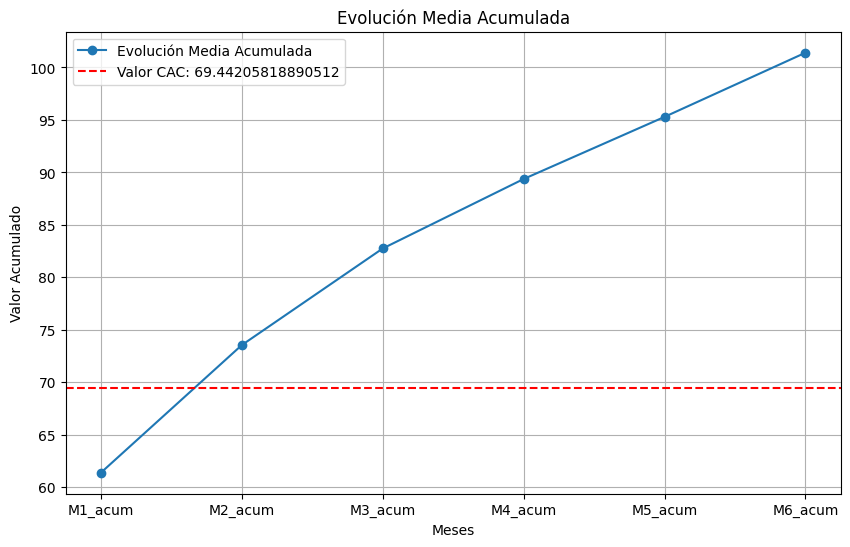

MesCliente
M1_acum     61.387632
M2_acum     73.549125
M3_acum     82.753108
M4_acum     89.372549
M5_acum     95.293254
M6_acum    101.407011
dtype: float64

In [21]:
evolucion_cliente(tabla_ltv, cac_medio)

# Plan de acción 1: Pre - Captación

## Crear tabla con los clientes de una cohorte reciente

In [22]:
clientes_c6 = resultados_filtrados[resultados_filtrados.MesCohorte == '2023-06']
clientes_c6     

,ID_Cliente,Fecha,ID_Transaccion,Categoria_Producto,Producto,Coste_Unitario,Cantidad,Precio_Unitario,Total_Venta,MesTransaccion,MesCohorte,MesCliente,CAC
20,8,2023-06-21,30687,LPF,IP5IL,2.52,6.0,4.89,29.34,2023-06-01,2023-06-01,M1,70.91
113,42,2023-06-03,27726,X52,GBFC5,5.87,3.0,7.85,23.55,2023-06-01,2023-06-01,M1,75.46
114,42,2023-09-23,45992,3WV,R6HKE,3.16,3.0,5.37,16.11,2023-09-01,2023-06-01,M4,75.46
115,42,2023-09-23,45992,1L6,MGZ43,9.17,3.0,17.13,51.39,2023-09-01,2023-06-01,M4,75.46
132,45,2023-06-06,28118,OXH,VU316,2.11,7.0,3.11,21.77,2023-06-01,2023-06-01,M1,36.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54379,1331,2023-06-30,32363,SIM,K1R89,11.42,3.0,14.70,44.10,2023-06-01,2023-06-01,M1,88.13
54382,4410,2023-06-14,29625,NX3,A9BRM,2.06,7.0,2.73,19.11,2023-06-01,2023-06-01,M1,10.78
54386,17228,2023-06-12,29249,R6E,B4KFE,4.84,5.0,5.62,28.10,2023-06-01,2023-06-01,M1,120.50
54403,17354,2023-06-29,32041,01F,RVG1H,1.47,3.0,1.68,5.04,2023-06-01,2023-06-01,M1,26.46


## Calcular venta total a cada cliente en cada cohorte

In [23]:
ltv_real_clientes_c6 = clientes_c6.groupby(['ID_Cliente','MesCliente'])['Total_Venta'].sum().reset_index()
ltv_real_clientes_c6

,ID_Cliente,MesCliente,Total_Venta
0,8,M1,29.34
1,42,M1,23.55
2,42,M4,67.50
3,45,M1,147.03
4,67,M1,264.66
...,...,...,...
2492,22179,M5,46.30
2493,22206,M1,76.68
2494,22206,M5,124.22
2495,22212,M1,3.96


## Crear tabla pivotada por cliente y cohorte

In [24]:
tabla_ltv_real_clientes_c6 = ltv_real_clientes_c6.pivot(index = 'ID_Cliente', columns = 'MesCliente', values = 'Total_Venta').fillna(0)
tabla_ltv_real_clientes_c6

MesCliente,M1,M2,M3,M4,M5,M6
ID_Cliente,,,,,,
8,29.34,0.00,0.0,0.0,0.00,0.0
42,23.55,0.00,0.0,67.5,0.00,0.0
45,147.03,0.00,0.0,0.0,0.00,0.0
67,264.66,0.00,0.0,0.0,0.00,0.0
157,7.29,0.00,0.0,0.0,0.00,0.0
...,...,...,...,...,...,...
22176,24.96,0.00,0.0,0.0,0.00,0.0
22179,35.32,31.76,0.0,0.0,46.30,0.0
22206,76.68,0.00,0.0,0.0,124.22,0.0


In [25]:
# Hacemos la suma de las compras de cada clientes

tabla_ltv_real_clientes_c6['ltv_real'] = tabla_ltv_real_clientes_c6.sum(axis=1)
tabla_ltv_real_clientes_c6

MesCliente,M1,M2,M3,M4,M5,M6,ltv_real
ID_Cliente,,,,,,,
8,29.34,0.00,0.0,0.0,0.00,0.0,29.34
42,23.55,0.00,0.0,67.5,0.00,0.0,91.05
45,147.03,0.00,0.0,0.0,0.00,0.0,147.03
67,264.66,0.00,0.0,0.0,0.00,0.0,264.66
157,7.29,0.00,0.0,0.0,0.00,0.0,7.29
...,...,...,...,...,...,...,...
22176,24.96,0.00,0.0,0.0,0.00,0.0,24.96
22179,35.32,31.76,0.0,0.0,46.30,0.0,113.38
22206,76.68,0.00,0.0,0.0,124.22,0.0,200.90


## Unir datos sociodemográficos

In [26]:
# Obtener sociodemograficos
sociodemo = clientes[['ID_Cliente', 'Genero', 'Nivel_Educativo', 'Ocupacion', 'Tamano_Hogar', 'CAC']]

In [27]:
tabla_ltv_real_clientes_c6_completa = tabla_ltv_real_clientes_c6.merge(sociodemo, on = 'ID_Cliente', how = 'left')
tabla_ltv_real_clientes_c6_completa

,ID_Cliente,M1,M2,M3,M4,M5,M6,ltv_real,Genero,Nivel_Educativo,Ocupacion,Tamano_Hogar,CAC
0,8,29.34,0.00,0.0,0.0,0.00,0.0,29.34,Mujer,Bachillerato,Autónomo,4-5 personas,70.91
1,42,23.55,0.00,0.0,67.5,0.00,0.0,91.05,Mujer,Máster,Autónomo,2-3 personas,75.46
2,45,147.03,0.00,0.0,0.0,0.00,0.0,147.03,Hombre,Máster,Desconocido,4-5 personas,36.08
3,67,264.66,0.00,0.0,0.0,0.00,0.0,264.66,Mujer,Universitario,Empleado,2-3 personas,70.00
4,157,7.29,0.00,0.0,0.0,0.00,0.0,7.29,Hombre,Universitario,Desempleado,4-5 personas,50.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,22176,24.96,0.00,0.0,0.0,0.00,0.0,24.96,Mujer,Educación básica,Empleado,4-5 personas,54.88
1457,22179,35.32,31.76,0.0,0.0,46.30,0.0,113.38,Mujer,Desconocido,Desempleado,2-3 personas,31.54
1458,22206,76.68,0.00,0.0,0.0,124.22,0.0,200.90,Mujer,Universitario,Desconocido,2-3 personas,24.46
1459,22212,3.96,0.00,0.0,0.0,0.00,0.0,3.96,Mujer,Sin estudios,Desconocido,2-3 personas,4.27


In [28]:
# Obtenemos CAC para esta cohorte

cac_medio_c6 = tabla_ltv_real_clientes_c6_completa.CAC.mean()
cac_medio_c6

np.float64(71.23369609856262)

## Obtener el punto muerto de cada sociodemográfico respecto a su CAC medio

In [29]:

import matplotlib.pyplot as plt

def analisis_punto_muerto(df, categoria, cac):
    # Crear columnas acumulativas para los meses M1 al M6
    df['M1_acum'] = df['M1']
    df['M2_acum'] = df[['M1', 'M2']].sum(axis=1)
    df['M3_acum'] = df[['M1', 'M2', 'M3']].sum(axis=1)
    df['M4_acum'] = df[['M1', 'M2', 'M3', 'M4']].sum(axis=1)
    df['M5_acum'] = df[['M1', 'M2', 'M3', 'M4', 'M5']].sum(axis=1)
    df['M6_acum'] = df[['M1', 'M2', 'M3', 'M4', 'M5', 'M6']].sum(axis=1)

    # Calcular la media de las columnas acumulativas
    acumulativas = ['M1_acum', 'M2_acum', 'M3_acum', 'M4_acum', 'M5_acum', 'M6_acum']
    medias_acumulativas = df[acumulativas].mean()

    # Crear el gráfico de líneas de la evolución media
    plt.figure(figsize=(10, 6))
    plt.plot(medias_acumulativas.index, medias_acumulativas.values, marker='o', label='Evolución media')

    # Añadir línea horizontal con el valor del CAC
    plt.axhline(y=cac, color='red', linestyle='--', label=f'Valor CAC: {cac}')

    # Mostrar la cuadrícula
    plt.grid(True)

    # Añadir etiquetas y título
    plt.title(f'Gráfico de la Categoría: {categoria}')
    plt.xlabel('Meses')
    plt.ylabel('Valor Acumulado')
    plt.legend()

    # Mostrar el gráfico
    plt.show()

    return medias_acumulativas

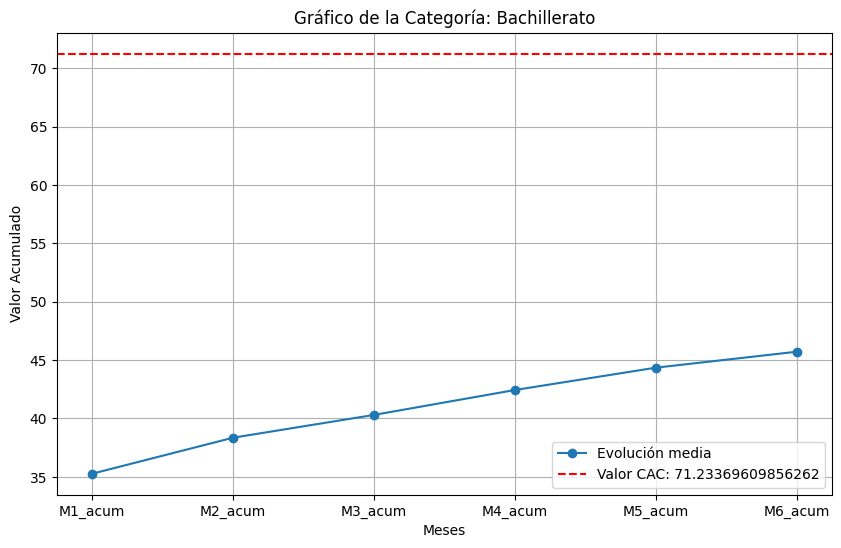

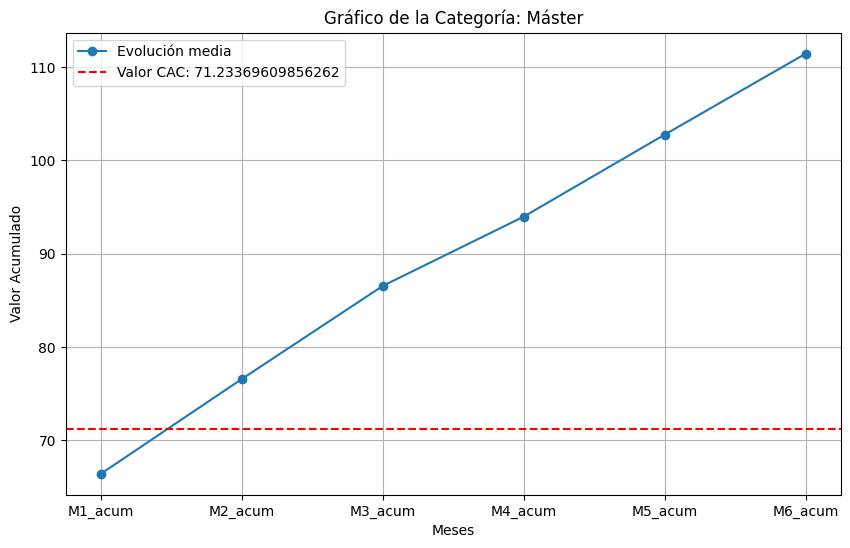

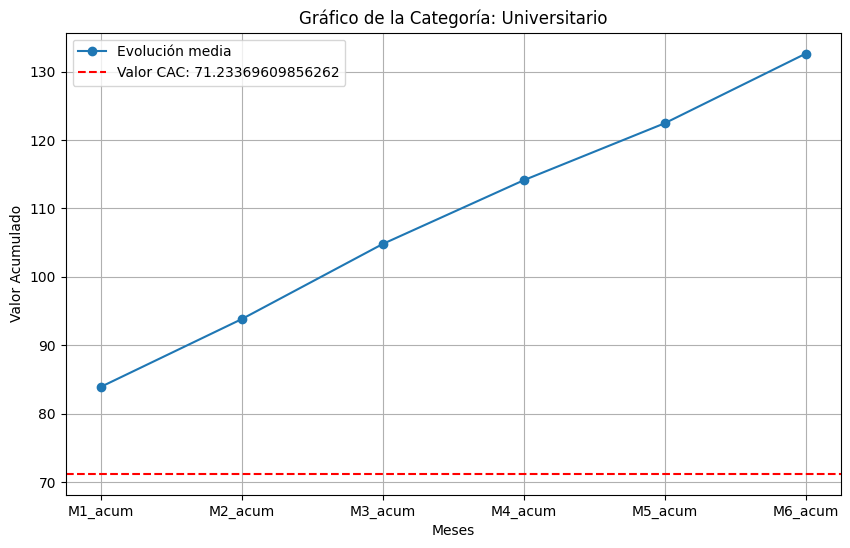

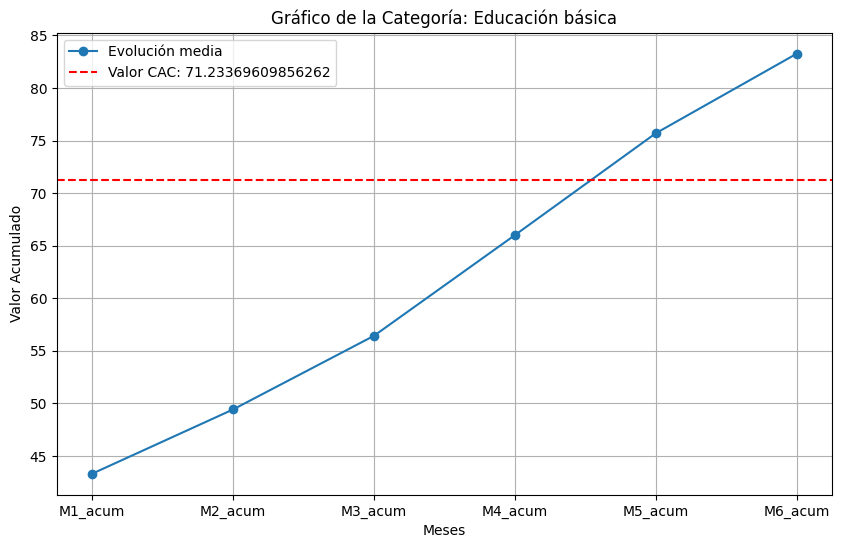

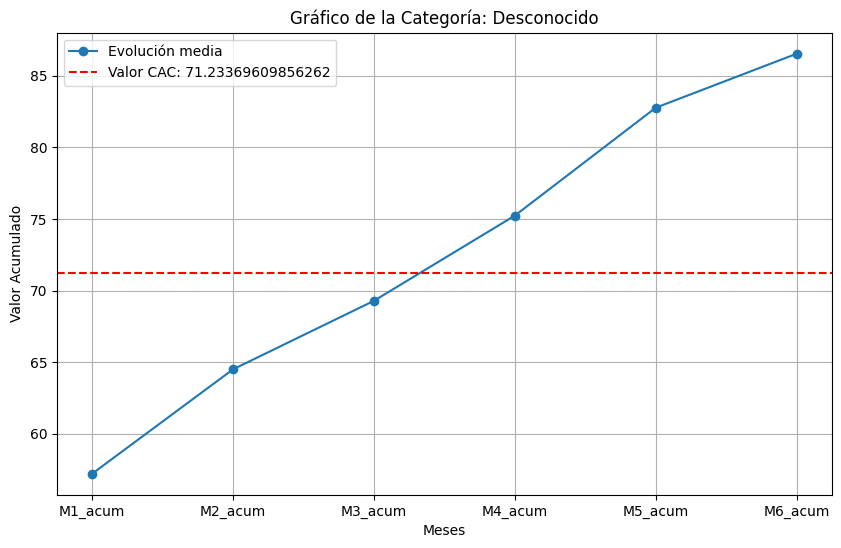

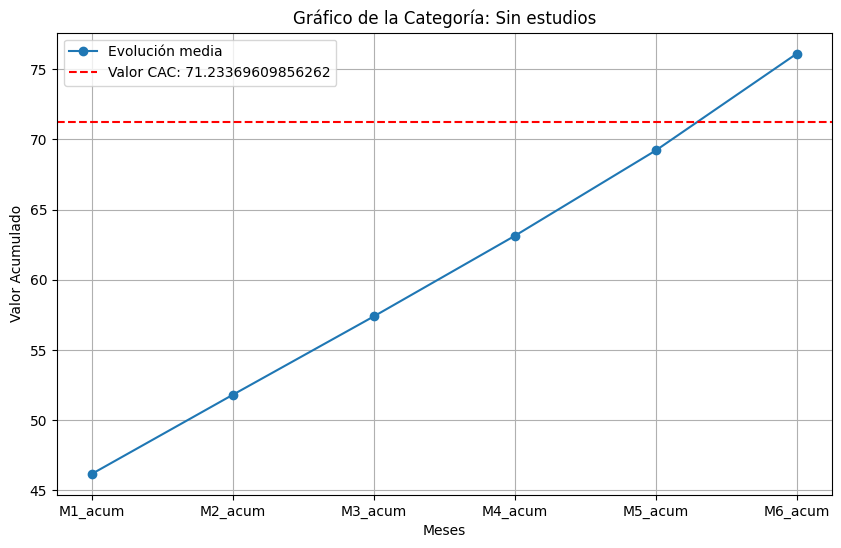

In [30]:
# Aplicar la función a Nivel Educativo

for cada in tabla_ltv_real_clientes_c6_completa.Nivel_Educativo.unique():
    df_temp = tabla_ltv_real_clientes_c6_completa[tabla_ltv_real_clientes_c6_completa['Nivel_Educativo'] == cada].copy()
    analisis_punto_muerto(df_temp,cada, cac_medio_c6)


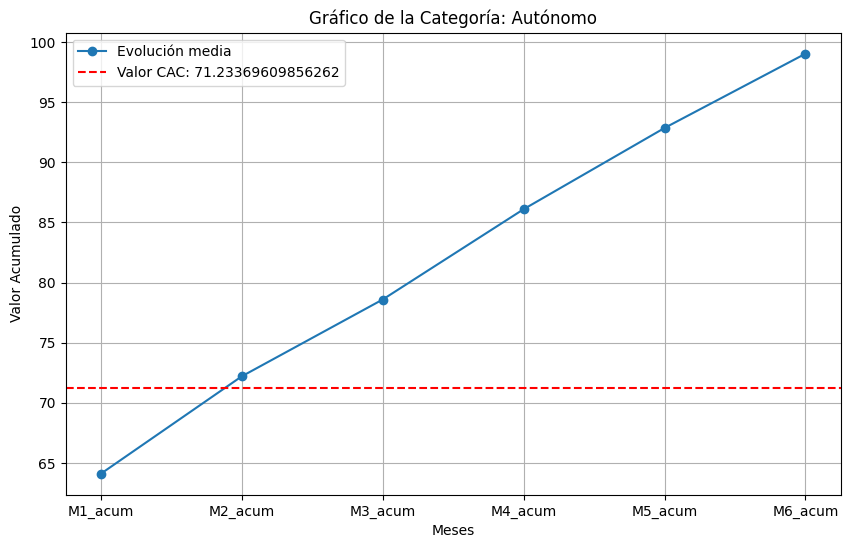

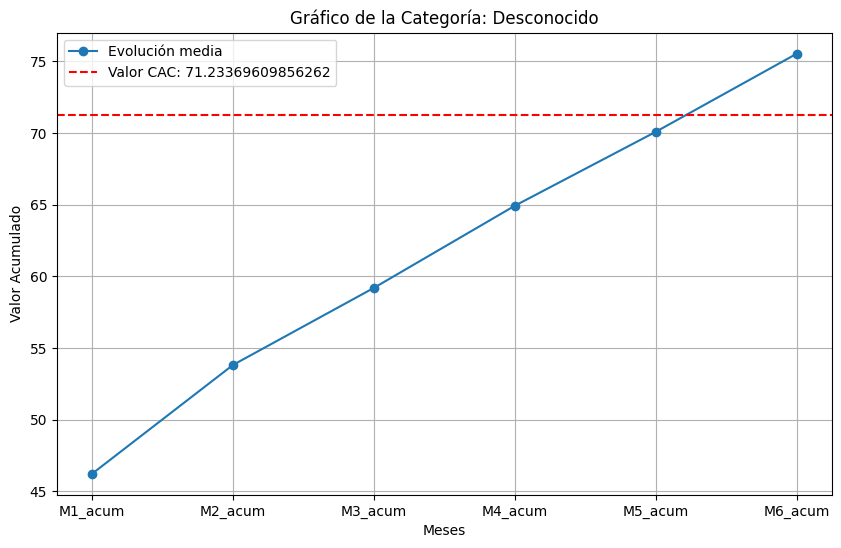

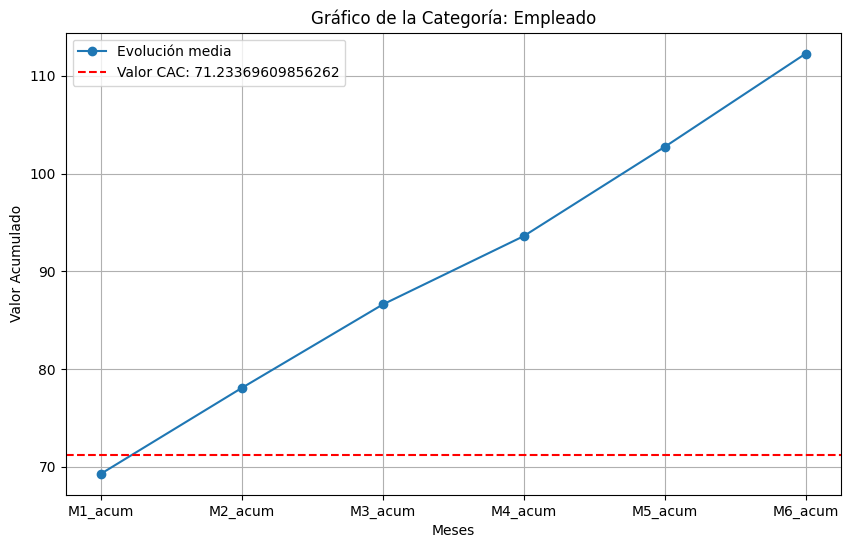

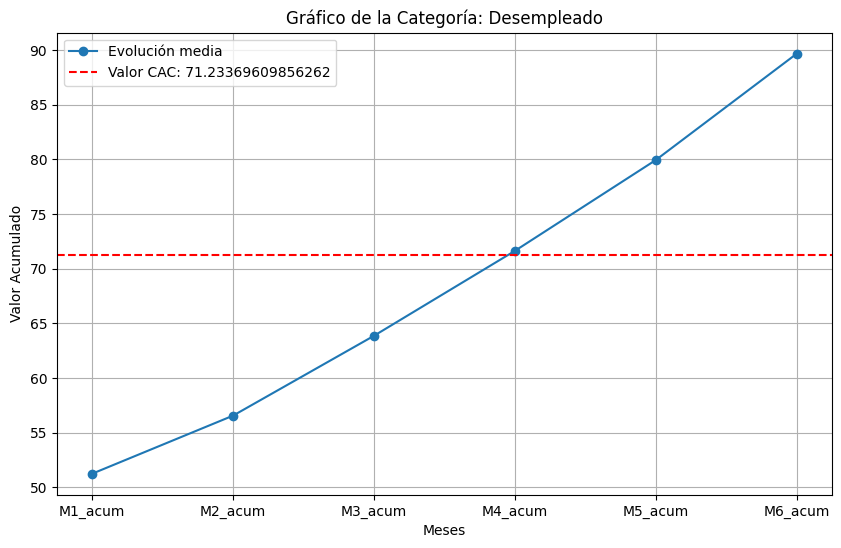

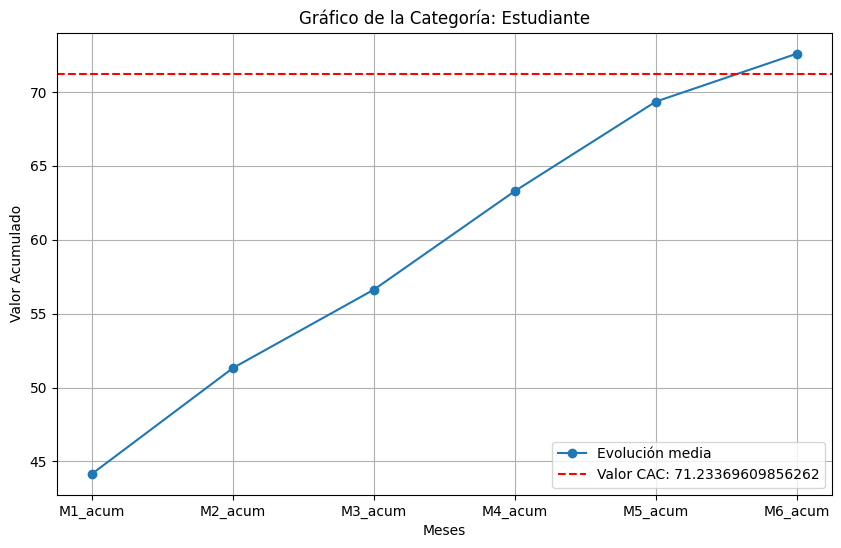

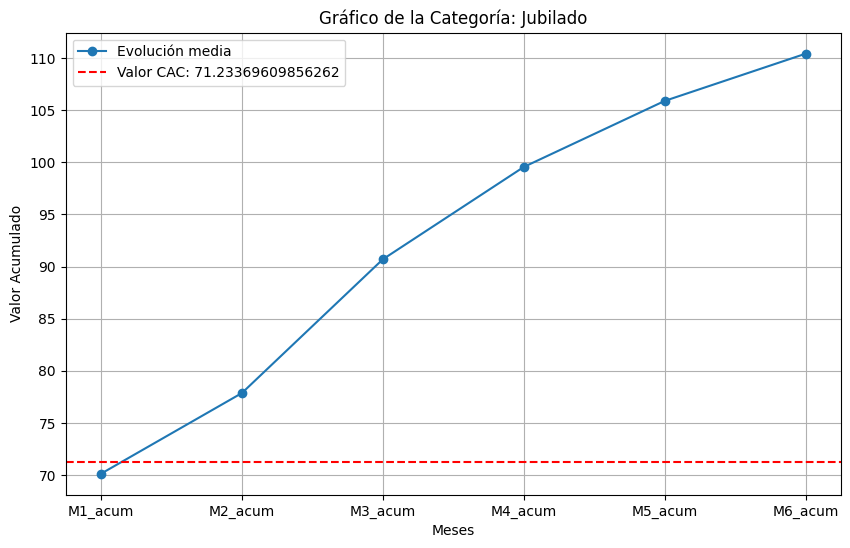

In [31]:
# Aplicar la función a Ocupación

for cada in tabla_ltv_real_clientes_c6_completa.Ocupacion.unique():
    df_temp = tabla_ltv_real_clientes_c6_completa[tabla_ltv_real_clientes_c6_completa['Ocupacion'] == cada].copy()
    analisis_punto_muerto(df_temp,cada, cac_medio_c6)

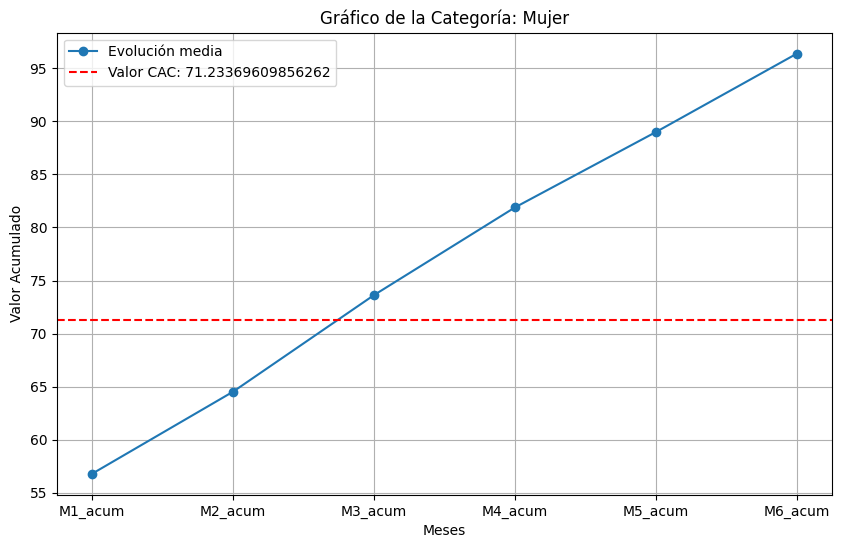

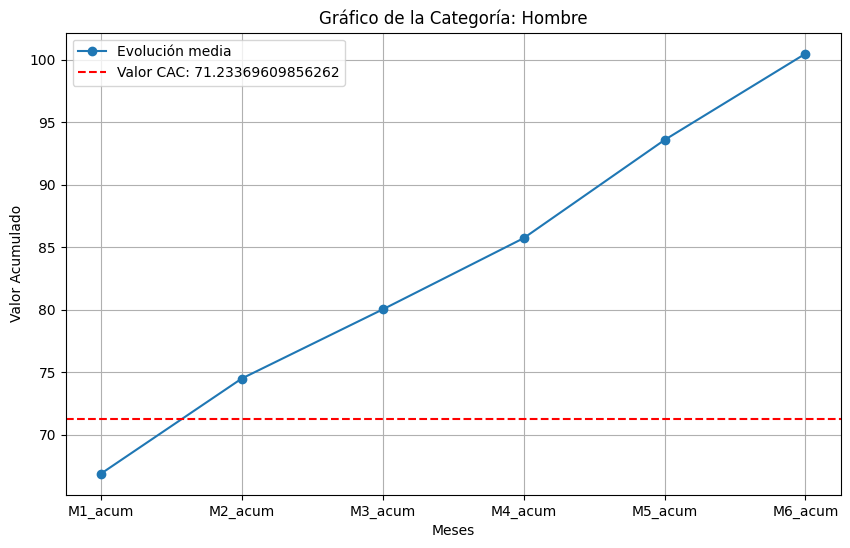

In [32]:
for cada in tabla_ltv_real_clientes_c6_completa.Genero.unique():
    df_temp = tabla_ltv_real_clientes_c6_completa[tabla_ltv_real_clientes_c6_completa['Genero'] == cada].copy()
    analisis_punto_muerto(df_temp,cada, cac_medio_c6)

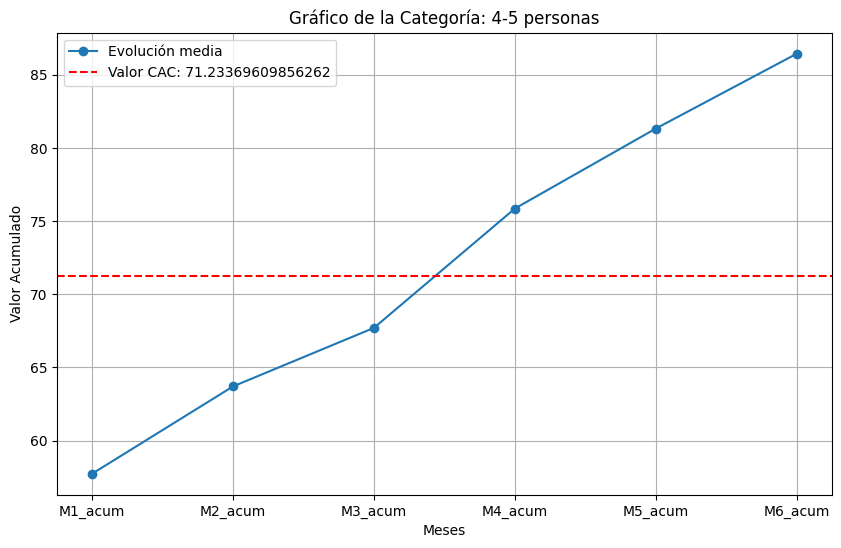

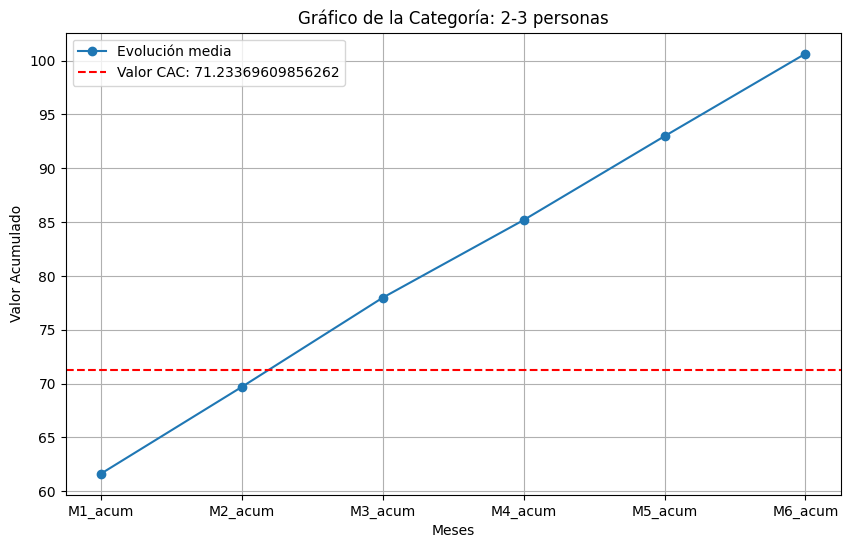

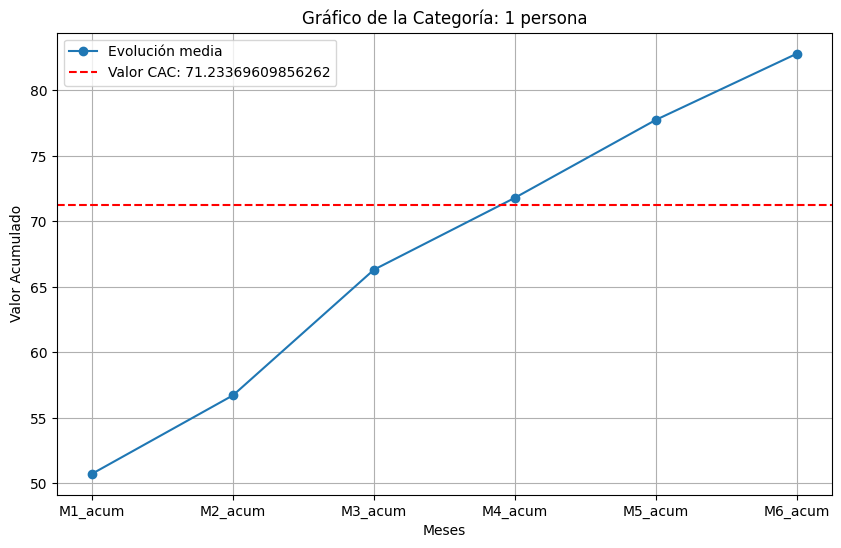

In [33]:
for cada in tabla_ltv_real_clientes_c6_completa.Tamano_Hogar.unique():
    df_temp = tabla_ltv_real_clientes_c6_completa[tabla_ltv_real_clientes_c6_completa['Tamano_Hogar'] == cada].copy()
    analisis_punto_muerto(df_temp,cada, cac_medio_c6)

# Plan de acción 2: captación

In [34]:
resultados_filtrados

,ID_Cliente,Fecha,ID_Transaccion,Categoria_Producto,Producto,Coste_Unitario,Cantidad,Precio_Unitario,Total_Venta,MesTransaccion,MesCohorte,MesCliente,CAC
0,1,2023-01-21,3442,0H2,6OUVC,7.64,4.0,10.50,42.00,2023-01-01,2023-01-01,M1,184.31
1,1,2023-01-21,3442,N8U,CEBU8,4.57,4.0,5.79,23.16,2023-01-01,2023-01-01,M1,184.31
2,2,2023-03-24,14177,TVL,2SLS0,4.60,3.0,7.77,23.31,2023-03-01,2023-03-01,M1,31.60
3,2,2023-06-19,30451,F9B,GZ6VU,9.04,3.0,15.00,45.00,2023-06-01,2023-03-01,M4,31.60
4,3,2023-01-01,90,LPF,Y1M2E,3.37,4.0,4.08,16.32,2023-01-01,2023-01-01,M1,29.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54400,2494,2023-07-27,36500,FU5,3ZY0H,3.34,3.0,4.96,14.88,2023-07-01,2023-07-01,M1,50.05
54401,3527,2023-04-28,20425,FEW,WG7HI,4.11,3.0,5.18,15.54,2023-04-01,2023-04-01,M1,196.24
54402,5063,2023-03-13,11915,29A,PO1N6,3.00,10.0,4.96,49.60,2023-03-01,2023-03-01,M1,46.72
54403,17354,2023-06-29,32041,01F,RVG1H,1.47,3.0,1.68,5.04,2023-06-01,2023-06-01,M1,26.46


In [38]:
# Calcular el LTV por cliente

ltv_cliente = resultados_filtrados.groupby('ID_Cliente')[['Total_Venta']].sum()
ltv_cliente.columns = ['ltv']
ltv_cliente

,ltv
ID_Cliente,
1,65.16
2,68.31
3,24.60
4,139.85
5,143.81
...,...
22232,21.00
22233,23.76
22234,221.28


## Incorporar los datos sociodemográficos

In [42]:
ltv_clientes_socio = ltv_cliente.merge(sociodemo, on = 'ID_Cliente', how = 'left')
ltv_clientes_socio

,ID_Cliente,ltv,Genero,Nivel_Educativo,Ocupacion,Tamano_Hogar,CAC
0,1,65.16,Hombre,Universitario,Empleado,4-5 personas,184.31
1,2,68.31,Hombre,Sin estudios,Empleado,1 persona,31.60
2,3,24.60,Mujer,Bachillerato,Estudiante,4-5 personas,29.33
3,4,139.85,Hombre,Bachillerato,Empleado,2-3 personas,63.67
4,5,143.81,Mujer,Universitario,Estudiante,2-3 personas,11.13
...,...,...,...,...,...,...,...
14362,22232,21.00,Hombre,Universitario,Autónomo,2-3 personas,48.37
14363,22233,23.76,Mujer,Universitario,Empleado,2-3 personas,20.30
14364,22234,221.28,Mujer,Máster,Jubilado,2-3 personas,81.66
14365,22235,14.72,Mujer,Bachillerato,Empleado,1 persona,10.36


In [45]:
ltv_socio = ltv_clientes_socio.groupby(['Nivel_Educativo','Ocupacion','Tamano_Hogar']).agg(
    ltv_medio = ('ltv', 'mean')).reset_index()
ltv_socio 

,Nivel_Educativo,Ocupacion,Tamano_Hogar,ltv_medio
0,Bachillerato,Autónomo,1 persona,99.243333
1,Bachillerato,Autónomo,2-3 personas,103.265793
2,Bachillerato,Autónomo,4-5 personas,94.159690
3,Bachillerato,Desconocido,1 persona,74.944286
4,Bachillerato,Desconocido,2-3 personas,84.373093
...,...,...,...,...
103,Universitario,Estudiante,2-3 personas,90.415714
104,Universitario,Estudiante,4-5 personas,78.176750
105,Universitario,Jubilado,1 persona,72.860000
106,Universitario,Jubilado,2-3 personas,102.503525


In [49]:
venta_media = resultados_filtrados.groupby('ID_Cliente')['Total_Venta'].sum().mean()
venta_media

np.float64(102.75640843599915)

## Tabla de clientes cohorte 6

In [50]:
tabla_ltv_real_clientes_c6_completa

,ID_Cliente,M1,M2,M3,M4,M5,M6,ltv_real,Genero,Nivel_Educativo,Ocupacion,Tamano_Hogar,CAC
0,8,29.34,0.00,0.0,0.0,0.00,0.0,29.34,Mujer,Bachillerato,Autónomo,4-5 personas,70.91
1,42,23.55,0.00,0.0,67.5,0.00,0.0,91.05,Mujer,Máster,Autónomo,2-3 personas,75.46
2,45,147.03,0.00,0.0,0.0,0.00,0.0,147.03,Hombre,Máster,Desconocido,4-5 personas,36.08
3,67,264.66,0.00,0.0,0.0,0.00,0.0,264.66,Mujer,Universitario,Empleado,2-3 personas,70.00
4,157,7.29,0.00,0.0,0.0,0.00,0.0,7.29,Hombre,Universitario,Desempleado,4-5 personas,50.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,22176,24.96,0.00,0.0,0.0,0.00,0.0,24.96,Mujer,Educación básica,Empleado,4-5 personas,54.88
1457,22179,35.32,31.76,0.0,0.0,46.30,0.0,113.38,Mujer,Desconocido,Desempleado,2-3 personas,31.54
1458,22206,76.68,0.00,0.0,0.0,124.22,0.0,200.90,Mujer,Universitario,Desconocido,2-3 personas,24.46
1459,22212,3.96,0.00,0.0,0.0,0.00,0.0,3.96,Mujer,Sin estudios,Desconocido,2-3 personas,4.27


In [67]:
tabla_ltv_real_clientes_c6_simplificada = tabla_ltv_real_clientes_c6_completa[['ID_Cliente','Nivel_Educativo','Ocupacion','Tamano_Hogar','ltv_real','CAC']].copy()
tabla_ltv_real_clientes_c6__simplificada 

,ID_Cliente,Nivel_Educativo,Ocupacion,Tamano_Hogar,ltv_real,CAC
0,8,Bachillerato,Autónomo,4-5 personas,29.34,70.91
1,42,Máster,Autónomo,2-3 personas,91.05,75.46
2,45,Máster,Desconocido,4-5 personas,147.03,36.08
3,67,Universitario,Empleado,2-3 personas,264.66,70.00
4,157,Universitario,Desempleado,4-5 personas,7.29,50.05
...,...,...,...,...,...,...
1456,22176,Educación básica,Empleado,4-5 personas,24.96,54.88
1457,22179,Desconocido,Desempleado,2-3 personas,113.38,31.54
1458,22206,Universitario,Desconocido,2-3 personas,200.90,24.46
1459,22212,Sin estudios,Desconocido,2-3 personas,3.96,4.27


## Incorporar el ltv predictivo

In [71]:
tabla_ltv_real_clientes_c6_simplificada2 = tabla_ltv_real_clientes_c6_simplificada.merge(ltv_socio, how = 'left', on = ['Nivel_Educativo','Ocupacion','Tamano_Hogar'])
tabla_ltv_real_clientes_c6_simplificada2 = tabla_ltv_real_clientes_c6_simplificada2.rename(columns = {'ltv_medio':'ltv_predicho'})
tabla_ltv_real_clientes_c6_simplificada2

,ID_Cliente,Nivel_Educativo,Ocupacion,Tamano_Hogar,ltv_real,CAC,ltv_predicho
0,8,Bachillerato,Autónomo,4-5 personas,29.34,70.91,94.159690
1,42,Máster,Autónomo,2-3 personas,91.05,75.46,172.072987
2,45,Máster,Desconocido,4-5 personas,147.03,36.08,65.555714
3,67,Universitario,Empleado,2-3 personas,264.66,70.00,120.900541
4,157,Universitario,Desempleado,4-5 personas,7.29,50.05,84.687342
...,...,...,...,...,...,...,...
1456,22176,Educación básica,Empleado,4-5 personas,24.96,54.88,76.165714
1457,22179,Desconocido,Desempleado,2-3 personas,113.38,31.54,73.948295
1458,22206,Universitario,Desconocido,2-3 personas,200.90,24.46,99.753345
1459,22212,Sin estudios,Desconocido,2-3 personas,3.96,4.27,50.321525


## Cálculo de los errores, real vs predicho

In [73]:
tabla_ltv_real_clientes_c6_simplificada2['error_real'] = abs(tabla_ltv_real_clientes_c6_simplificada2['ltv_real'] - venta_media)
tabla_ltv_real_clientes_c6_simplificada2['error_predicho'] = abs(tabla_ltv_real_clientes_c6_simplificada2['ltv_predicho'] - venta_media)
tabla_ltv_real_clientes_c6_simplificada2

,ID_Cliente,Nivel_Educativo,Ocupacion,Tamano_Hogar,ltv_real,CAC,ltv_predicho,error_real,error_predicho
0,8,Bachillerato,Autónomo,4-5 personas,29.34,70.91,94.159690,73.416408,8.596719
1,42,Máster,Autónomo,2-3 personas,91.05,75.46,172.072987,11.706408,69.316578
2,45,Máster,Desconocido,4-5 personas,147.03,36.08,65.555714,44.273592,37.200694
3,67,Universitario,Empleado,2-3 personas,264.66,70.00,120.900541,161.903592,18.144132
4,157,Universitario,Desempleado,4-5 personas,7.29,50.05,84.687342,95.466408,18.069067
...,...,...,...,...,...,...,...,...,...
1456,22176,Educación básica,Empleado,4-5 personas,24.96,54.88,76.165714,77.796408,26.590694
1457,22179,Desconocido,Desempleado,2-3 personas,113.38,31.54,73.948295,10.623592,28.808113
1458,22206,Universitario,Desconocido,2-3 personas,200.90,24.46,99.753345,98.143592,3.003063
1459,22212,Sin estudios,Desconocido,2-3 personas,3.96,4.27,50.321525,98.796408,52.434883


In [74]:
tabla_ltv_real_clientes_c6_simplificada2.error_real.mean()

np.float64(74.12370934904008)

In [75]:
tabla_ltv_real_clientes_c6_simplificada2.error_predicho.mean()

np.float64(17.951625401200292)

In [ ]:
# # Código LTV unificado:

# # Calcular el CAC medio

# # resultados_filtrados = resultados_filtrados.merge(
#     clientes[['ID_Cliente', 'CAC']],
#     on = 'ID_Cliente',
#     how = 'left'
# )

# # Agregamos a nivel de clientes

# cac_cliente = resultados_filtrados.groupby('ID_Cliente')['CAC'].first()
# #
# cac_medio = cac_cliente.mean()

# # Calcular el LTV por cliente

# ltv_cliente = resultados_filtrados.groupby('ID_Cliente')[['Total_Venta']].sum()
# ltv_cliente.columns = ['ltv']

In [ ]:
# Código LTV unificado:

# Calcular el CAC medio

resultados_filtrados = resultados_filtrados.merge(
    clientes[['ID_Cliente', 'CAC']],
    on = 'ID_Cliente',
    how = 'left'
)

# Agregamos a nivel de clientes

cac_cliente = resultados_filtrados.groupby('ID_Cliente')['CAC'].first()
#
cac_medio = cac_cliente.mean()

# Calcular el LTV por cliente

ltv_cliente = resultados_filtrados.groupby('ID_Cliente')[['Total_Venta']].sum()
ltv_cliente.columns = ['ltv']